In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# This relates to plotting datetime values with matplotlib

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [5]:
df = pd.read_csv('./PYTORCH_NOTEBOOKS/Data/TimeSeriesData/Alcohol_Sales.csv',index_col=0,parse_dates=True)
print(df.head())
print(df.tail())

            S4248SM144NCEN
DATE                      
1992-01-01            3459
1992-02-01            3458
1992-03-01            4002
1992-04-01            4564
1992-05-01            4221
            S4248SM144NCEN
DATE                      
2018-09-01           12396
2018-10-01           13914
2018-11-01           14174
2018-12-01           15504
2019-01-01           10718


In [6]:
df.columns

Index(['S4248SM144NCEN'], dtype='object')

In [7]:
len(df)

325

In [8]:
df.dropna()
len(df)

325

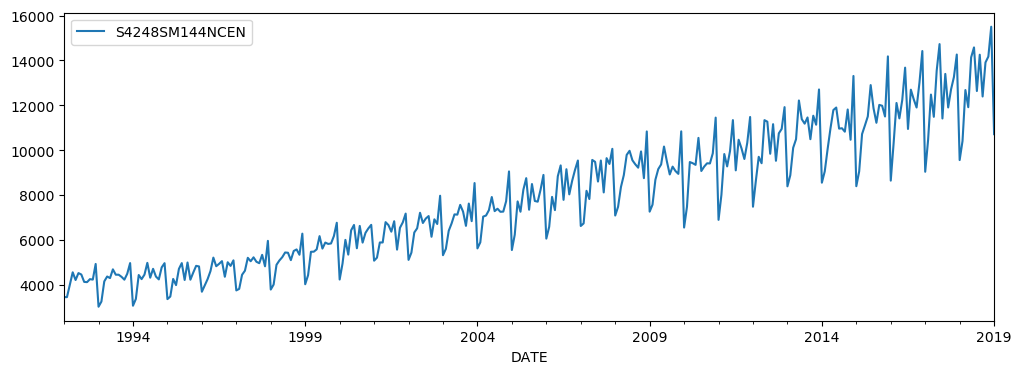

In [10]:
df.plot(figsize=(12,4))

In [11]:
y = df['S4248SM144NCEN'].values.astype(float)

In [12]:
print(y)

[ 3459.  3458.  4002.  4564.  4221.  4529.  4466.  4137.  4126.  4259.
  4240.  4936.  3031.  3261.  4160.  4377.  4307.  4696.  4458.  4457.
  4364.  4236.  4500.  4974.  3075.  3377.  4443.  4261.  4460.  4985.
  4324.  4719.  4374.  4248.  4784.  4971.  3370.  3484.  4269.  3994.
  4715.  4974.  4223.  5000.  4235.  4554.  4851.  4826.  3699.  3983.
  4262.  4619.  5219.  4836.  4941.  5062.  4365.  5012.  4850.  5097.
  3758.  3825.  4454.  4635.  5210.  5057.  5231.  5034.  4970.  5342.
  4831.  5965.  3796.  4019.  4898.  5090.  5237.  5447.  5435.  5107.
  5515.  5583.  5346.  6286.  4032.  4435.  5479.  5483.  5587.  6176.
  5621.  5889.  5828.  5849.  6180.  6771.  4243.  4952.  6008.  5353.
  6435.  6673.  5636.  6630.  5887.  6322.  6520.  6678.  5082.  5216.
  5893.  5894.  6799.  6667.  6374.  6840.  5575.  6545.  6789.  7180.
  5117.  5442.  6337.  6525.  7216.  6761.  6958.  7070.  6148.  6924.
  6716.  7975.  5326.  5609.  6414.  6741.  7144.  7133.  7568.  7266.
  6634

In [13]:
test_size = 12

In [14]:
train_set = y[:-test_size]
test_set = y[-test_size:]

In [15]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

In [16]:
# Normalizing Data
# RNN's work better with normalized data

In [17]:
from sklearn.preprocessing import MinMaxScaler

C:\Users\ila66\anaconda3\envs\pytorchenv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [19]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [20]:
scaler.fit(train_set.reshape(-1,1)) # An inplace command

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [21]:
train_norm = scaler.transform(train_set.reshape(-1,1))

In [22]:
train_norm = torch.FloatTensor(train_norm).view(-1)

In [23]:
window_size = 12

In [24]:
def input_data(seq,ws):
    
    out = []
    L = len(seq)
    
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [25]:
train_data = input_data(train_norm,window_size)

In [26]:
print(len(train_data))

301


In [27]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

In [28]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

In [29]:
torch.manual_seed(101)
model = LSTMnetwork()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [30]:
model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [31]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.25314361
Epoch:  2 Loss: 0.37523878
Epoch:  3 Loss: 0.39012104
Epoch:  4 Loss: 0.34949684
Epoch:  5 Loss: 0.33077890
Epoch:  6 Loss: 0.33230731
Epoch:  7 Loss: 0.32667685
Epoch:  8 Loss: 0.32077038
Epoch:  9 Loss: 0.30651766
Epoch: 10 Loss: 0.29517013
Epoch: 11 Loss: 0.26913923
Epoch: 12 Loss: 0.25979319
Epoch: 13 Loss: 0.24599983
Epoch: 14 Loss: 0.22227521
Epoch: 15 Loss: 0.18593518
Epoch: 16 Loss: 0.18445997
Epoch: 17 Loss: 0.17433715
Epoch: 18 Loss: 0.25819331
Epoch: 19 Loss: 0.22410871
Epoch: 20 Loss: 0.23153940
Epoch: 21 Loss: 0.19832778
Epoch: 22 Loss: 0.19958292
Epoch: 23 Loss: 0.19348034
Epoch: 24 Loss: 0.16432090
Epoch: 25 Loss: 0.13512717
Epoch: 26 Loss: 0.13356653
Epoch: 27 Loss: 0.13493073
Epoch: 28 Loss: 0.02778251
Epoch: 29 Loss: 0.05438356
Epoch: 30 Loss: 0.00163427
Epoch: 31 Loss: 0.00142721
Epoch: 32 Loss: 0.02253861
Epoch: 33 Loss: 0.04568101
Epoch: 34 Loss: 0.03575871
Epoch: 35 Loss: 0.03850965
Epoch: 36 Loss: 0.00281272
Epoch: 37 Loss: 0.00155254
E

In [32]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [33]:
# Inverting the normalization
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[10521.85233352],
       [12514.88419873],
       [11754.35282286],
       [13334.48005062],
       [14449.88239342],
       [11461.24476567],
       [13546.48186153],
       [12004.45329618],
       [12727.70047325],
       [13133.26779068],
       [14027.46864921],
       [ 9743.29415134]])

In [34]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [38]:
# Plotting results
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime6')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

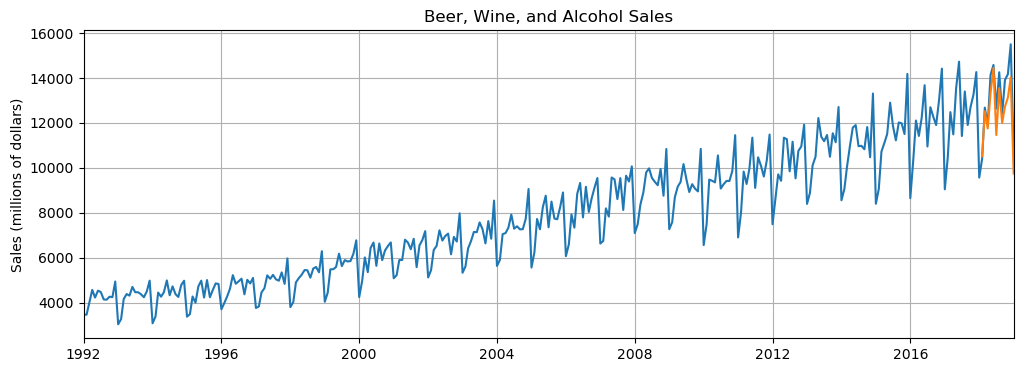

In [39]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

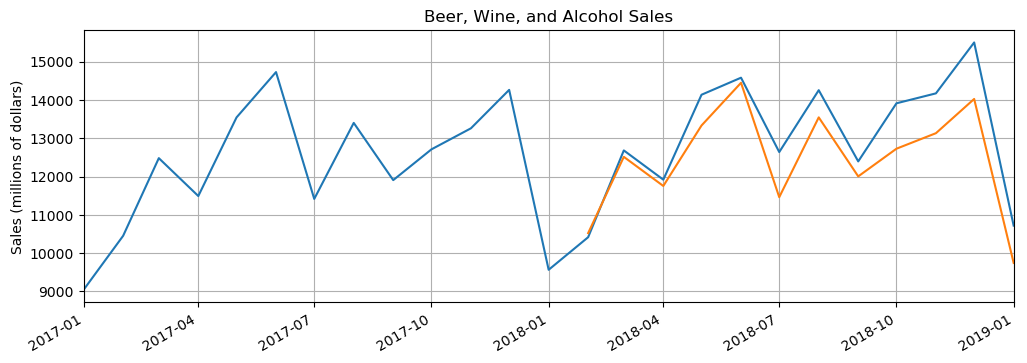

In [40]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

# Forecast into an unknown future
This time we'll continue training the model using the entire dataset, and predict 12 steps into the future.

In [41]:
epochs = 100

model.train()
y_norm = scaler.fit_transform(y.reshape(-1,1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    for seq, y_train in all_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.01950295
Epoch:  2 Loss: 0.02763573
Epoch:  3 Loss: 0.02464899
Epoch:  4 Loss: 0.01851161
Epoch:  5 Loss: 0.01569259
Epoch:  6 Loss: 0.01271221
Epoch:  7 Loss: 0.00664524
Epoch:  8 Loss: 0.00040204
Epoch:  9 Loss: 0.01125507
Epoch: 10 Loss: 0.01162904
Epoch: 11 Loss: 0.01420694
Epoch: 12 Loss: 0.01161343
Epoch: 13 Loss: 0.01421821
Epoch: 14 Loss: 0.01551901
Epoch: 15 Loss: 0.01364133
Epoch: 16 Loss: 0.01414355
Epoch: 17 Loss: 0.01346371
Epoch: 18 Loss: 0.01226602
Epoch: 19 Loss: 0.01200523
Epoch: 20 Loss: 0.01221264
Epoch: 21 Loss: 0.01283381
Epoch: 22 Loss: 0.01499686
Epoch: 23 Loss: 0.01272402
Epoch: 24 Loss: 0.01255908
Epoch: 25 Loss: 0.01218850
Epoch: 26 Loss: 0.01120988
Epoch: 27 Loss: 0.01192996
Epoch: 28 Loss: 0.01134722
Epoch: 29 Loss: 0.01627929
Epoch: 30 Loss: 0.01066889
Epoch: 31 Loss: 0.00906866
Epoch: 32 Loss: 0.00887503
Epoch: 33 Loss: 0.01243216
Epoch: 34 Loss: 0.00915066
Epoch: 35 Loss: 0.01927456
Epoch: 36 Loss: 0.00773916
Epoch: 37 Loss: 0.00409337
E

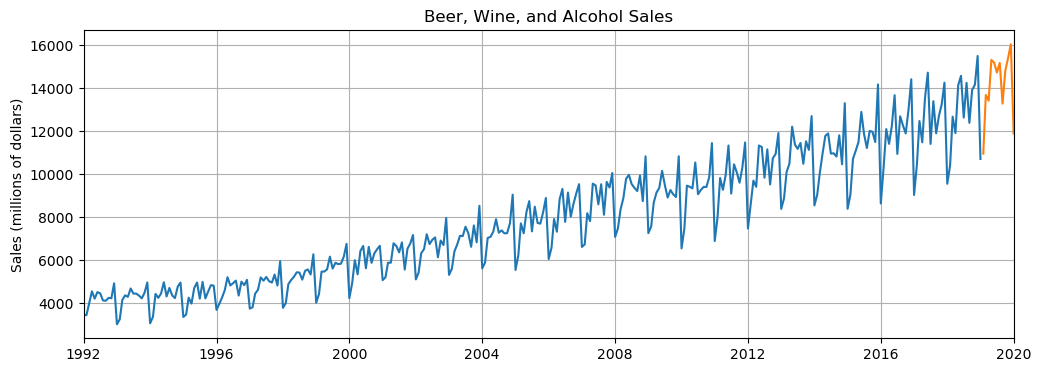

In [42]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# PLOT THE RESULT
# Set a data range for the predicted data.
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

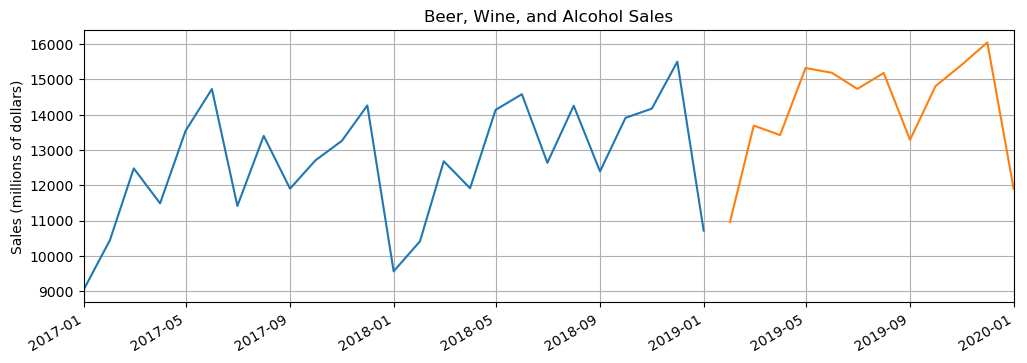

In [43]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()

In [44]:
torch.save(model.state_dict(),'./Models/BEER_RNN.pt')